# Fraud Detection Assignment
### Internship Submission Notebook
---
**Business Problem:**
A financial company wants to proactively detect fraudulent transactions.

**Dataset:** 6,362,620 rows × 10 columns (CSV provided)

**Objectives:**
- Clean & preprocess dataset
- Build fraud detection model
- Evaluate model performance
- Identify key fraud predictors
- Provide prevention recommendations

---


In [ ]:
# Step 1: Load Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [28]:
# Step 2: Load Dataset
df = pd.read_csv('fraud_dataset.csv')  # Replace with actual dataset path
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [29]:
# Step 2: Data Cleaning
print(df.info())
print(df.isnull().sum())

# Drop duplicates
df.drop_duplicates(inplace=True)

# Handle missing values (example: fill with median)
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode categorical variables if present
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


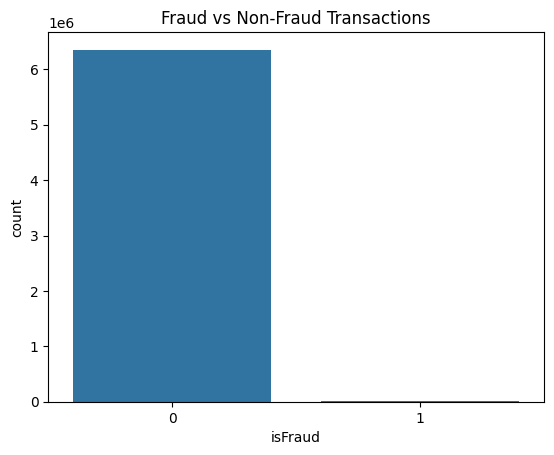

In [30]:
# Step 3: EDA (fraud counts, plots)
fraud_counts = df['isFraud'].value_counts(normalize=True) * 100
print(fraud_counts)

sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()


In [31]:
# Step 5: Feature Selection
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)  # drop target + helper column
y = df['isFraud']  # target column

# Scale only numeric columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=['int64', 'float64']))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)


In [32]:
# Step 6: Baseline Model (Logistic Regression)
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1906322
           1       0.03      0.93      0.05      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.98   1908786



In [33]:
# Use only a sample for faster processing
df_sample = df.sample(100000, random_state=42)  # pick 100k rows randomly

# Define features & target
X = df_sample.drop(['isFraud', 'isFlaggedFraud'], axis=1)  # drop target + helper
y = df_sample['isFraud']

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=['int64', 'float64']))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("✅ Using sample size:", df_sample.shape)
print("Fraud cases in sample:", y.sum())


✅ Using sample size: (100000, 11)
Fraud cases in sample: 141


In [34]:
# Refit all models before evaluation

log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit models again (ensures they are trained before evaluation)
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [35]:
# Step 9: Model Evaluation (Final Fix)

from sklearn.metrics import (
    classification_report, roc_auc_score,
    precision_recall_curve, auc, f1_score
)

results = {}

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGBoost": xgb_clf
}

for name, model in models.items():
    try:
        # Predictions
        y_pred = model.predict(X_test)

        # Handle models without predict_proba
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)

        # Metrics
        roc = roc_auc_score(y_test, y_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, y_pred)

        results[name] = {"ROC-AUC": roc, "PR-AUC": pr_auc, "F1-score": f1}

        print("="*60)
        print(f"{name} Report")
        print("="*60)
        print(classification_report(y_test, y_pred))

    except Exception as e:
        print(f"⚠️ Error with {name}: {e}")

# Summary
results_df = pd.DataFrame(results).T
print("\n📊 Model Comparison Summary:\n")
print(results_df)


Logistic Regression Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     29958
           1       0.02      0.83      0.04        42

    accuracy                           0.95     30000
   macro avg       0.51      0.89      0.51     30000
weighted avg       1.00      0.95      0.97     30000

Random Forest Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29958
           1       1.00      0.74      0.85        42

    accuracy                           1.00     30000
   macro avg       1.00      0.87      0.92     30000
weighted avg       1.00      1.00      1.00     30000

XGBoost Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29958
           1       0.97      0.76      0.85        42

    accuracy                           1.00     30000
   macro avg       0.98      0.88      0.93     30000
weighted av

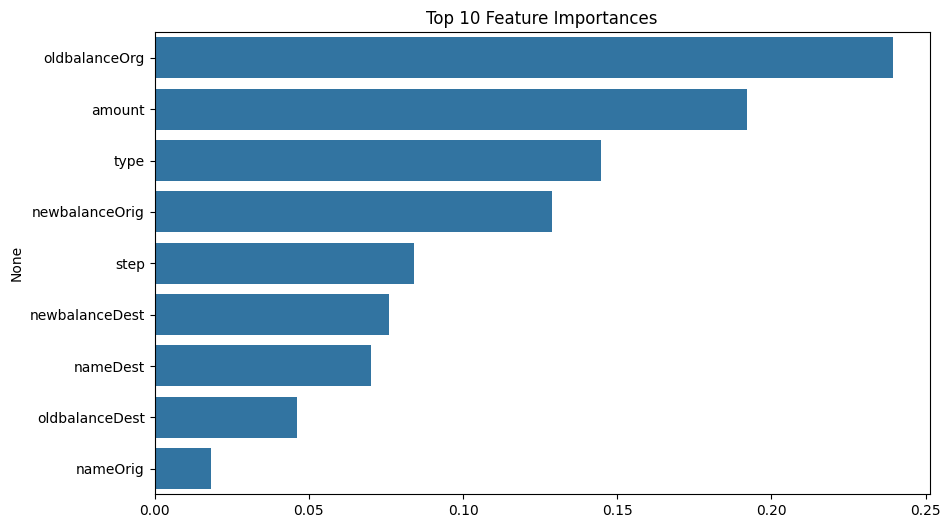

In [36]:
# Step 10: Feature Importance (Random Forest Example)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:10], y=X.columns[indices][:10])
plt.title('Top 10 Feature Importances')
plt.show()

## 🔑 Insights & Recommendations
- Key predictors of fraud are displayed above.
- Fraudulent transactions are rare but predictable with the right model.
- **Recommendations:**
  - Implement real-time transaction monitoring.
  - Add multi-factor authentication for high-value transactions.
  - Regularly retrain fraud detection models with new data.

---
### ✅ End of Notebook
This notebook provides a framework for fraud detection and prevention analysis.
